# Notebook getting EarthCare data over regions of interest.

## To do:
- [x] read in model data
- [x] read in EarthCare data
- [x] time and area filter for EarthCare data
- [x] extract model data along satellite tracks (time and space) 'curtains'
- [x] interpolation to smooth the curtains?
- [x] plot curtains 
- [ ] comparisons of model and satellite data
- [x] query EarthCare catalogue to make it easier to get data

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
# from pylab import *
# from matplotlib.colors import LinearSegmentedColormap
# from scipy.interpolate import interp1d
import pandas as pd
import easygems.healpix as egh
import easygems.remap as egr
import matplotlib.pyplot as plt
import h5py
import datetime
import glob 
import intake
from pathlib import Path
import healpy
import cmcrameri as scm5
import cartopy.crs as ccrs
from matplotlib.gridspec import GridSpec
import cartopy.feature as cfeature
import track_datetime


# plt.rcParams.update({'font.size': 14, 'font.family': 'TimesNewRoman', 'text.usetex': True})
# plt.rcParams['figure.dpi'] = 300
# rcParams['axes.linewidth'] = 1.5

In [2]:
#Load some fancy colourmaps if you would like
batlow=plt.get_cmap(scm5.cm.batlow)
hawaii=plt.get_cmap(scm5.cm.hawaii)
glasgow=plt.get_cmap(scm5.cm.glasgow)


In [3]:
def get_earthcare_dat_hackathon(date, time, product='level2-CPR',):
    """

    """
    base='/work/mh0731/m301196/ecomip/ftp.eorc.jaxa.jp'
    products={'level1' : {'path' : 'eorc/CPR/1B/xCa/2024', 'pref' : 'ECA_J_CPR_NOM_1BS_' , 'mid': '', 'suff' : '_vCa_corr_xCa.nc'},
              'level2-CPR' : {'path' : 'CPR/2A/CPR_CLP/vBa', 'pref' : 'ECA_J_CPR_CLP_2AS_' , 'mid': '', 'suff' : '_04814E_vBa.h5' },
              'level2-CPR-DV' : {'path' :'CPR/2A/CPR_ECO/vBa', 'pref' : 'ECA_J_CPR_ECO_2AS_', 'mid': '', 'suff' : '_04814C_vBa.h5'},
              'level2-ATLID' : {'path' : 'ATL/2A/ATL_CLA/vBa', 'pref' : 'ECA_J_ATL_CLA_2AS_', 'mid': '', 'suff' : '_04876E_vBa.h5'},
    }

    
    yy,mm,dd=date.split('-',2)
    hr,mn=time.split('T',1)[1].split(':',2)[0:2]
    target=datetime.datetime(int(yy),int(mm),int(dd),int(hr),int(mn))

    

    files=glob.glob(f"{base}/{products[product]['path']}/{yy}/{mm}/{dd}/{products[product]['pref']}{yy}{mm}{dd}*")
    times=np.zeros(len(files))

    file_datetime = datetime.datetime(int(yy),int(mm),int(dd),int(hr),int(mn))

    for i,file in enumerate(files):
        hr=file.split('T',1)[1].split('_',1)[0][0:2]
        mn=file.split('T',1)[1].split('_',1)[0][2:]
        file_datetime = datetime.datetime(int(yy),int(mm),int(dd),int(hr),int(mn))
        
        times[i]=(target-file_datetime).seconds


    times=np.abs(times)
    filename=files[np.where(times==np.min(times))[0][0]] #File with time closest to that which is specified

    print(filename)

    ec_lat,ec_lon,ec_time,ec_height=get_h5_geodat(filename) if product!='level1' else print('need to read netcdf file')

    return ec_lat, ec_lon, ec_time, ec_height, filename

In [4]:
def get_earthcare_dat(date, time, product='CPR_CLD_2A'):
    """
    If you have downloaded data using the get_ec_data script then use this.
    """

    base='/work/bb1086/b383354/earth-care-data'

    yy,mm,dd=date.split('-',2)
    hr,mn=time.split('T',1)[1].split(':',2)[0:2]

    filename=glob.glob(f"{base}/{yy}/{mm}/{dd}/*{product}*{yy}{mm}{dd}*T{hr}{mn}*.h5")[0]
    print(filename)

    ec_lat,ec_lon,ec_time,ec_height=get_h5_geodat(filename)

    return ec_lat, ec_lon, ec_time, ec_height, filename

    
    

In [5]:
# for getting simple sections from models

def get_nest(ds):
    return ds.crs.healpix_order == "nest"


def get_section(ds,lons,lats,var):
    pnts = xr.DataArray(
    healpy.ang2pix(healpy.get_nside(ds[var]), lons, lats, lonlat=True, nest=get_nest(ds[var])),
    dims=("cell",),
    coords={"lon": (("cell",), lons), "lat": (("cell",), lats)},
)

    return ds[var].isel(cell=pnts).swap_dims({"cell": "lon"})#.plot(x="lon", yincrease=False)

In [6]:
#Functions for exploring and reading HDF5 data

def get_h5_geodat(filename):
    """
    Use h5_explore to check the file structure, you may need to edit
    the paths in order to extract the data of interest for you. 
    """
    with h5py.File(filename, "r") as f:
        lat = f["ScienceData/latitude"][:]
        lon = f["ScienceData/longitude"][:]
        time = f["ScienceData/time"][:]
        height = f["ScienceData/height"][:]

    return lat,lon,time,height



def explore_h5(filename):
    with h5py.File(filename, "r") as f:
        def explorer(groupe, indent=0):
            for key in groupe:
                item = groupe[key]
                print("  " * indent + key, "(groupe)" if isinstance(item, h5py.Group) else "(dataset)")
                if isinstance(item, h5py.Group):
                    explorer(item, indent + 1)

        explorer(f)
        

    

In [7]:
def interpolate_to_track2(ds, weights_file, track_lon, track_lat):
   
    if weights_file.is_file():
        print("loading existing interpolation weights for this EC track")
        weights = xr.open_dataset(weights_file)
    else:
        print("computing weights using Delaunay triangulation")
        ds = (
            ds.rename_dims({"value": "cell"}).pipe(egh.attach_coords)
            if "value" in ds.dims
            else ds.pipe(egh.attach_coords)
        )
        weights = egr.compute_weights_delaunay(
            points=(ds["lon"].values, ds["lat"].values),
            xi=(track_lon, track_lat),
        )
        weights.to_netcdf(weights_file)

    # Apply weights to interpolate the dataset
    ds_interpolated = xr.apply_ufunc(
        egr.apply_weights,
        ds,
        kwargs=weights,
        input_core_dims=[["cell"]],
        output_core_dims=[["track"]],
        output_dtypes=["f4"],
        vectorize=True,
        dask="parallelized",
        dask_gufunc_kwargs={
            "output_sizes": {"track": len(track_lon)},
        },
        keep_attrs=True,
        on_missing_core_dim='copy'
    )

    return ds_interpolated

In [8]:
# you can load a track_datetime object to see what times and dates tracks go over your region
svalbard_tracks=track_datetime.read_from_pickle('/work/bb1086/b383354/earth-care-data/track_datetimes/svalbard_track_datetimes.pkl')
svalbard_tracks.dates

{'2025-04-09': ['T13:59:00'],
 '2025-04-01': ['T23:59:00'],
 '2025-04-05': ['T14:21:00'],
 '2025-04-13': ['T21:19:00'],
 '2025-04-17': ['T14:47:00'],
 '2025-04-14': ['T20:27:00'],
 '2025-04-16': ['T20:16:00'],
 '2025-04-18': ['T15:28:00'],
 '2025-04-12': ['T16:01:00'],
 '2025-04-03': ['T22:15:00'],
 '2025-04-21': ['T14:25:00'],
 '2025-04-27': ['T21:34:00'],
 '2025-04-28': ['T14:32:00'],
 '2025-04-24': ['T14:54:00'],
 '2025-04-26': ['T14:43:00'],
 '2025-04-22': ['T16:38:00'],
 '2025-04-15': ['T22:41:00'],
 '2025-04-19': ['T20:46:00'],
 '2025-04-06': ['T16:35:00'],
 '2025-04-07': ['T00:17:00'],
 '2025-04-04': ['T16:46:00'],
 '2025-04-20': ['T13:44:00'],
 '2025-04-25': ['T14:03:00'],
 '2025-04-23': ['T17:19:00'],
 '2025-04-29': ['T16:45:00']}

In [10]:
## Set some params

# model_day = "2020-04-03"  # format 'YYYY-MM-DD'   
# ec_time = "T19:20:00"  # format T'hh:mm:ss'
# ec_day= "2025-04-01" 
# ec_lon_min = -60  # degrees
# ec_lon_max = -20  # degrees
# ec_lat_min = 60  # degrees
# ec_lat_max = 80  # degrees



model_day = "2020-04-05"  # format 'YYYY-MM-DD'   
ec_time = "T14:21:00"  # format T'hh:mm:ss'
ec_day= "2025-04-05" 

ec_lon_min = None  # degrees
ec_lon_max = None  # degrees
ec_lat_min = None  # degrees
ec_lat_max = None  # degrees

modelsets=['casesm2_10km_nocumulus',
           'icon_d3hp003',
           'ifs_tco3999-ng5_rcbmf_cf',
           'nicam_gl11',
           'scream-dkrz',
           'um_glm_n2560_RAL3p3'
          ]

model='icon_d3hp003'   #--------> just for now, later we loop over the different models
zoom=7
current_location='EU'

########################################################
## Now we need to get the track from the satellite data#
########################################################

# below is for EC data which was downloaded for the hackathon
# ec_track_lat, ec_track_lon, ec_track_time, ec_track_height, ec_filename = get_earthcare_dat_hackathon(ec_day, ec_time, product='level2-CPR')

#below is for EC data downloaded using the get_ec_data script
ec_track_lat, ec_track_lon, ec_track_time, ec_track_height, ec_filename = get_earthcare_dat(ec_day, ec_time, product='ATL_ICE_2A')

# # # %% Trim track coordinates to be within the lat/lon bounds

valid_indices = np.where(
    (ec_track_lon >= (ec_lon_min if ec_lon_min != None else -180))
    & (ec_track_lon <= (ec_lon_max if ec_lon_max != None else 180))
    & (ec_track_lat >= (ec_lat_min if ec_lat_min != None else -90))
    & (ec_track_lat <= (ec_lat_max if ec_lat_max != None else 90)) 
)[0]
ec_track_lon = ec_track_lon[valid_indices]
ec_track_lat = ec_track_lat[valid_indices]
ec_track_time = ec_track_time[valid_indices]

print(len(ec_track_lon))


/work/bb1086/b383354/earth-care-data/2025/04/05/ECA_EXAE_ATL_ICE_2A_20250405T142149Z_20250405T161913Z_04849C.h5
4844


In [11]:
#Now load a model 

cat = intake.open_catalog(
    "https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml"
)[current_location]
ds = cat[model](zoom=zoom).to_dask()
ds=ds.sel(time=f"{model_day}{ec_time}",method='nearest')
ds = ds.pipe(egh.attach_coords) 

# %% Interpolating the dataset to the EarthCARE track
ds_lon_deg = np.degrees(ds["lon"].values)
ds_lat_deg = np.degrees(ds["lat"].values)

suff1,suff2=ec_filename.split('_')[6:8]
suff=f"{suff1}_{suff2}"

# ds_curtain = interpolate_to_track(
#     ds, ec_track_lon, ec_track_lat, ds_lon_deg, ds_lat_deg, suff, model, zoom
# )

weights_file = Path(
        f"/work/mh0492/m301067/hackaton25/auxiliary-files/weights/weights_ec_tracks_{suff}_{model}_zoom{str(zoom)}.nc"
    )

ds_curtain = interpolate_to_track2(
    ds, weights_file, ec_track_lon, ec_track_lat
)

# Add track longitude, latitude, and time to the curtain datafile
ds_curtain = ds_curtain.assign(
    lon=("track", ec_track_lon.data),
    lat=("track", ec_track_lat.data),
)

/work/bb1086/b383354/conda/envs/hackathon/lib/python3.10/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


computing weights using Delaunay triangulation


## Simple sections
Take a simple section along the track and plot - must select the vairable to plot

/tmp/ipykernel_3327890/1157312903.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(np.round(np.linspace(min(ps),max(ps),len(ylabs)-1)))
/tmp/ipykernel_3327890/1157312903.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(np.round(np.linspace(min(lons),max(lons),len(xlabs)-1),1))


Text(0.5, 0, 'Longitude (Degrees East)')

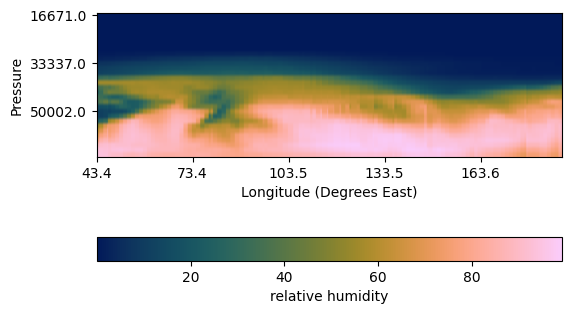

In [15]:
var='hur'
longname=ds[var].long_name
sect = get_section(ds,ec_track_lon,ec_track_lat,'hur')

plot_imshow=True


fig,ax=plt.subplots(figsize=(6,7))
ps=sect['pressure'].values
lons=sect['lon'].values
if plot_imshow:
    cont=ax.imshow(sect.values,aspect=50,cmap=batlow)
    xlabs=ax.get_xticks()
    ylabs=ax.get_yticks()
    ax.set_yticklabels(np.round(np.linspace(min(ps),max(ps),len(ylabs)-1)))
    ax.set_xticklabels(np.round(np.linspace(min(lons),max(lons),len(xlabs)-1),1))
else:
    cont=ax.contourf(lons,ps,sect.values,levels=50,cmap=batlow)
    plt.gca().invert_yaxis()

plt.colorbar(cont,orientation='horizontal',label=longname)
ax.set_ylabel('Pressure')
ax.set_xlabel('Longitude (Degrees East)')


/tmp/ipykernel_3489045/3987669373.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(np.round(np.linspace(min(ps),max(ps),len(ylabs)-1)))
/tmp/ipykernel_3489045/3987669373.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(np.round(np.linspace(min(lons),max(lons),len(xlabs)-1),1))


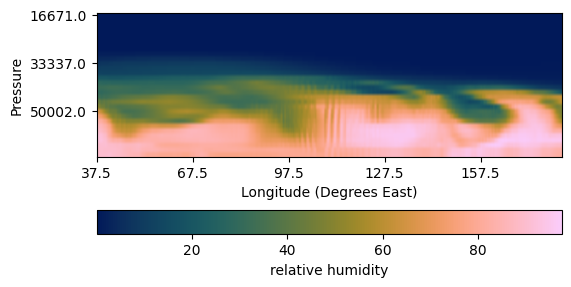

In [23]:
fig,ax=plt.subplots(figsize=(6,7))
fig,ax,cbar=plot_curtain(ds_curtain,'hur',ax=ax,fig=fig,cmap=batlow,pad_cbar=0.1)


In [20]:
def plot_curtain(ds, field, ax=None, fig=None, contour=False, cmap='viridis', pad_cbar=0.7, orientation='horizontal'):
    if ax==None or fig==None:
        fig,ax=plt.subplots(figsize=(6,7))
    
    if not contour:
        cont=ax.imshow(ds[field].values,aspect=50,cmap=cmap)
        xlabs=ax.get_xticks()
        ylabs=ax.get_yticks()
        ps=ds['pressure'].values
        lons=ds['lon'].values
        longname=ds[field].long_name
        ax.set_yticklabels(np.round(np.linspace(min(ps),max(ps),len(ylabs)-1)))
        ax.set_xticklabels(np.round(np.linspace(min(lons),max(lons),len(xlabs)-1),1))
    else:
        cont=ax.contourf(lons,ps,ds[field].values,levels=50,cmap=cmap)
        plt.gca().invert_yaxis()

    cbar=plt.colorbar(cont,orientation=orientation,label=longname, pad=pad_cbar)
    ax.set_ylabel('Pressure')
    ax.set_xlabel('Longitude (Degrees East)')


    return fig, ax, cbar


In [ ]:
def plot_sect(sect, longname, ax=None, fig=None, cmap='viridis',contour=False):
    if ax==None or fig==None:
        fig,ax=plt.subplots(figsize=(6,7))
    
    ps=sect['pressure'].values
    lons=sect['lon'].values
    

    if not contour:
        cont=ax.imshow(sect.values,aspect=50,cmap=cmap)
        xlabs=ax.get_xticks()
        ylabs=ax.get_yticks()
        ax.set_yticklabels(np.round(np.linspace(min(ps),max(ps),len(ylabs)-1)))
        ax.set_xticklabels(np.round(np.linspace(min(lons),max(lons),len(xlabs)-1),1))
    else:
        cont=ax.contourf(lons,ps,sect.values,levels=50,cmap=cmap)
        plt.gca().invert_yaxis()

    cbar=plt.colorbar(cont,orientation='horizontal',label=longname)
    ax.set_ylabel('Pressure')
    ax.set_xlabel('Longitude (Degrees East)')

    return fig,ax,cbar

In [136]:
field='hur'
longname=ds[field].long_name
sect = get_section(ds,ec_track_lon,ec_track_lat,field)
fig,ax,cbar=plot_sect(sect,longname,ax=ax,fig=fig,cmap=batlow)

/tmp/ipykernel_966678/304334893.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(np.round(np.linspace(min(ps),max(ps),len(ylabs)-1)))
/tmp/ipykernel_966678/304334893.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(np.round(np.linspace(min(lons),max(lons),len(xlabs)-1),1))
/tmp/ipykernel_966678/304334893.py:17: UserWarning: Adding colorbar to a different Figure <Figure size 600x700 with 6 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cbar=plt.colorbar(cont,orientation='horizontal',label=longname)


<Figure size 640x480 with 0 Axes>

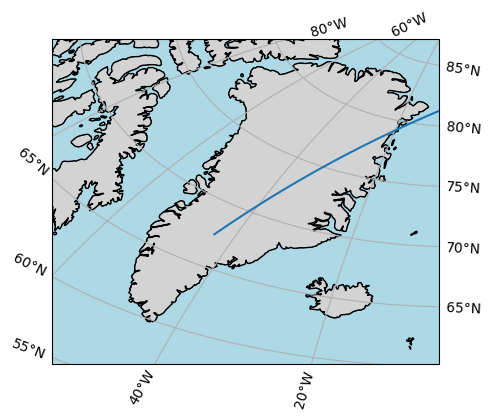

In [104]:
crs=ccrs.AzimuthalEquidistant()
fig,ax=plt.subplots(figsize=(5,5),subplot_kw={'projection':crs})

ax.set_extent([-60,-12,60,85],crs=ccrs.PlateCarree())

ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.OCEAN,facecolor='lightblue')
ax.add_feature(cfeature.LAND,facecolor='lightgray')
ax.gridlines(draw_labels=True)

ax.plot(ec_track_lon,ec_track_lat,transform=ccrs.PlateCarree())

/tmp/ipykernel_3327890/2430266090.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(np.round(np.linspace(min(ps),max(ps),len(ylabs)-1)))
/tmp/ipykernel_3327890/2430266090.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(np.round(np.linspace(min(lons),max(lons),len(xlabs)-1),1))


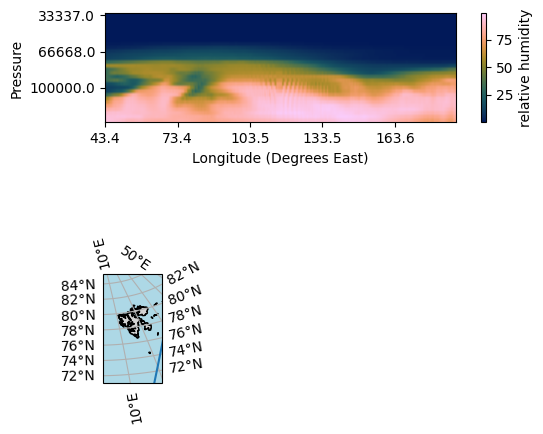

In [36]:
fig = plt.figure()
gs = GridSpec(3, 3)

# LEFT
ax1 = fig.add_subplot(gs[-1, 0], projection = ccrs.AzimuthalEquidistant(
        ))
ax1.coastlines(linewidth=0.5)
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS)
ax1.add_feature(cfeature.OCEAN,facecolor='lightblue')
ax1.add_feature(cfeature.LAND,facecolor='lightgray')
ax1.gridlines(draw_labels=True)
ax1.plot(ec_track_lon,ec_track_lat,transform=ccrs.PlateCarree())
ax1.set_extent([5,20,71,85],crs=ccrs.PlateCarree())

# # RIGHT TOP
ax1 = fig.add_subplot(gs[0, :])
ax1,fig,cbar=plot_curtain(ds_curtain,'hur',ax=ax1,fig=fig,cmap=batlow, orientation='vertical', pad_cbar=0.05)

# # RIGHT BOTTOM
# ax = fig.add_subplot(gs[1, 1])
# ax.plot(np.arange(0, 1000, 100))




## Plotting EarthCare data

The below is an example from the Curtains group for getting EarthCare data available on Levante and plotting.

/work/bb1086/b383354/conda/envs/hackathon/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/work/bb1086/b383354/conda/envs/hackathon/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:482: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


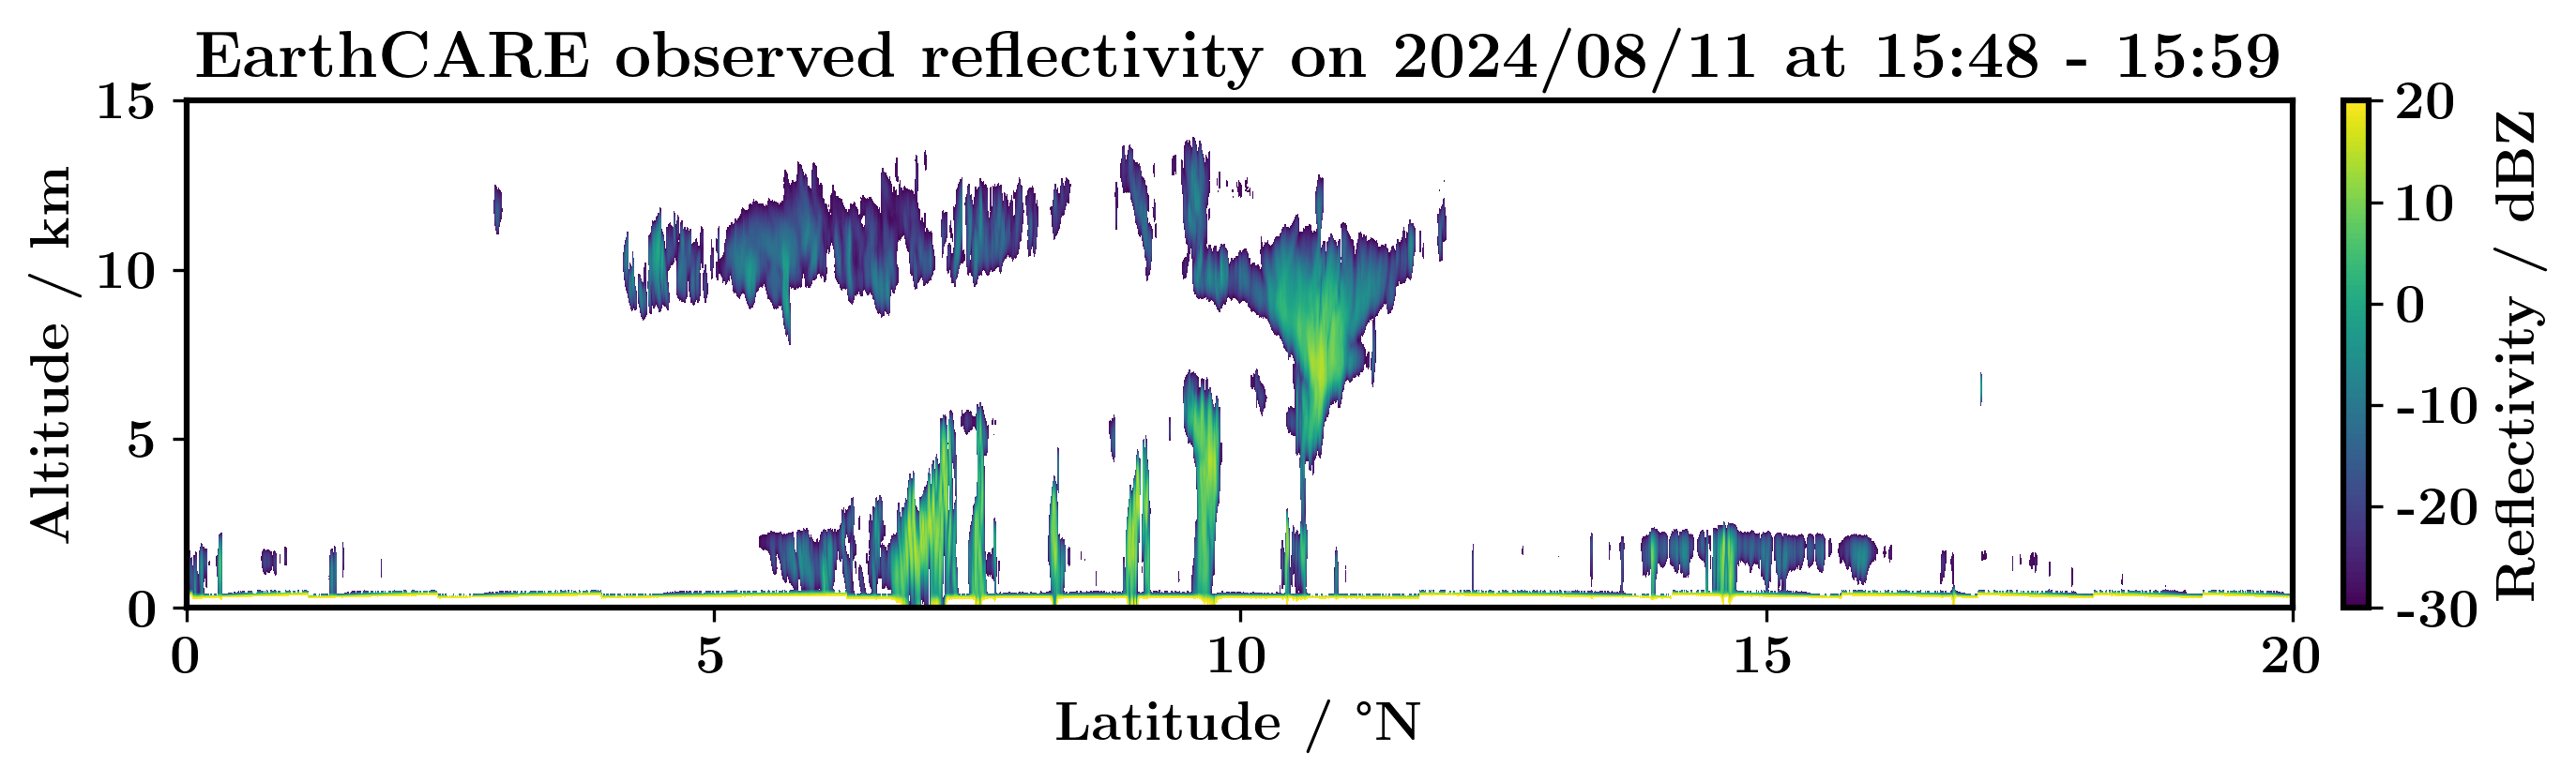

In [50]:
day = file_earthcare.split('T')[0][:10]
first_earthcare_time = file_earthcare.split('T')[1][:4]
second_earthcare_time = file_earthcare.split('T')[2][:4]
first_earthcare_time = first_earthcare_time[:2]+":"+first_earthcare_time[2:4]
second_earthcare_time = second_earthcare_time[:2]+":"+second_earthcare_time[2:4]

#Maybe you don't need the interpolation for now but it will be useful to compare with the models
#Interpolate bin with height to create a 1D altitude field
altitude_1d = ds_earthcare["height"].mean(dim="ray").values  # Compute the mean height across all rays for each bin
valid_mask = ~np.isnan(altitude_1d)
altitude_clean = altitude_1d[valid_mask]
ds_ec_interpolated = ds_earthcare.isel(bin=np.where(valid_mask)[0])

ds_ec_interpolated = ds_ec_interpolated.assign_coords(altitude=("bin", altitude_clean))
ds_ec_interpolated = ds_ec_interpolated.swap_dims({"bin": "altitude"})

ds_ec_interpolated2 = xr.Dataset()
for var in ds_ec_interpolated.data_vars:
    if 'altitude' in ds_ec_interpolated[var].dims:
        ds_ec_interpolated2[var] = ds_ec_interpolated[var].interp(altitude=zz, method='linear')
    else:
        ds_ec_interpolated2[var]=ds_ec_interpolated[var]

reflectivity = ds_ec_interpolated2['reflectivity']
reflectivity = np.where(reflectivity < -31, np.nan, reflectivity) # Delete noise

height = ds_ec_interpolated2['altitude']
lat = ds_ec_interpolated2['lat']
lon = ds_ec_interpolated2['lon']

# #PLOTTING
#Prepare the reflectivity scale
vmin = -30
vmax = 20
colorbar_ticks = np.arange(-30, vmax + 1, 10)

plt.figure(figsize=(10, 3))

contour = plt.contourf(
        lat, 
        height, 
        reflectivity.transpose(), 
        levels=np.linspace(vmin, vmax, 100),  # Ensure consistent levels
        vmin=vmin,
        vmax=vmax,
        
    )

plt.title(r'\textbf{EarthCARE observed reflectivity on ' + f'{day}' + ' at ' + f'{first_earthcare_time} - {second_earthcare_time}' + '}')
plt.xlabel(r'\textbf{Latitude / °N}')
plt.xticks([0, 5, 10, 15, 20], labels=[r'\textbf{0}', r'\textbf{5}', r'\textbf{10}', r'\textbf{15}', r'\textbf{20}'])
plt.ylabel(r'\textbf{Altitude / km}')
plt.yticks([0, 5000, 10000, 15000], labels=[r'\textbf{0}', r'\textbf{5}', r'\textbf{10}', r'\textbf{15}'])  # Set y-ticks at specific values

plt.xlim(0, 20)
plt.ylim(0, 15000)

cbar = plt.colorbar(contour, ticks=colorbar_ticks, pad=0.02)
cbar.set_label(r'\textbf{Reflectivity / dBZ}', color='black')
cbar.ax.set_yticklabels([f'\\textbf{{{tick}}}' for tick in colorbar_ticks])

plt.tight_layout()
plt.show()